# Time Series Forecasting

In [190]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import statsmodels.api as sm

## Loading Dataset

In [122]:
df = pd.read_csv('data_ADANIPORTS.csv', index_col = 'Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2008-05-06,134.313477,151.149994,153.570007,147.820007,150.000000,1782030.0
2008-05-07,136.232864,153.309998,154.460007,150.240005,152.000000,1180015.0
2008-05-08,138.525497,155.889999,156.759995,150.199997,152.199997,1856245.0
2008-05-09,139.085312,156.520004,160.600006,154.210007,155.000000,3251375.0
2008-05-12,144.399170,162.500000,163.479996,151.000000,156.000000,5031635.0


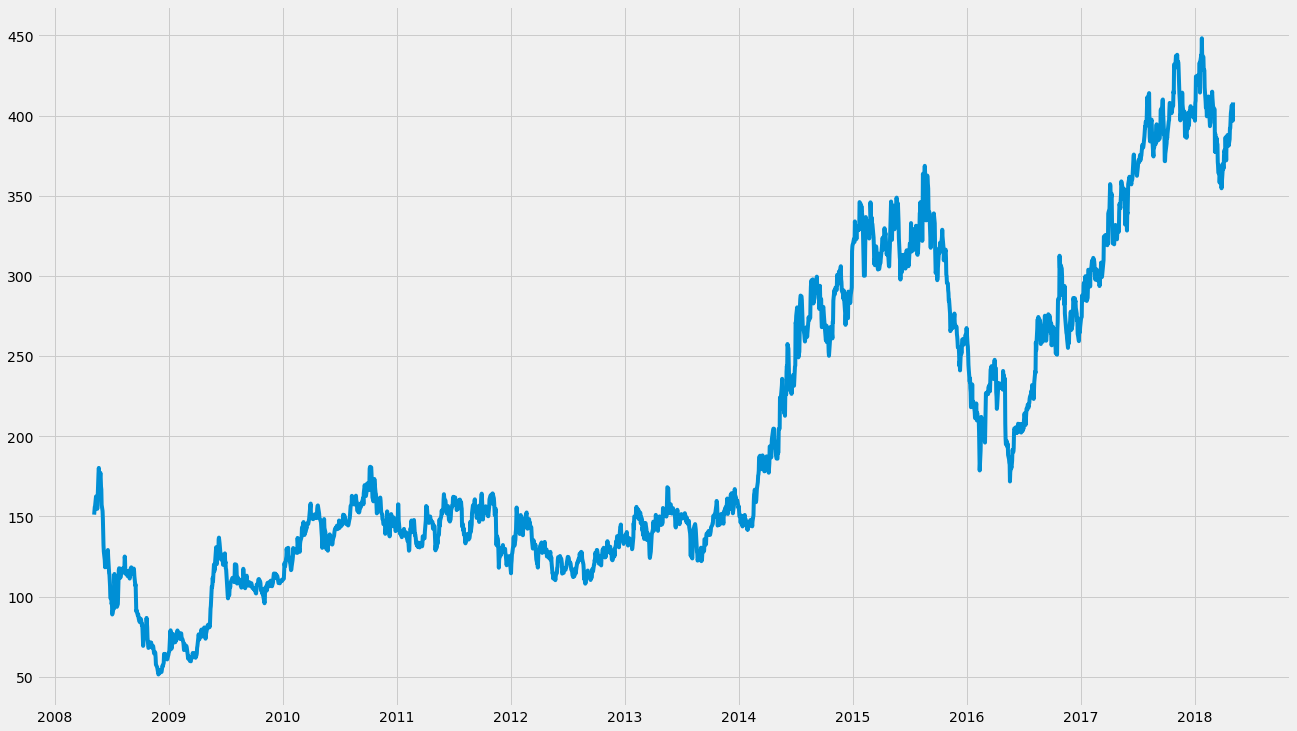

In [123]:
plt.plot(df['Close'])

A Time Series consists of three systematic components including level, trend, seasonality and a non systematic component called noise

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

## ADF (Augmented Dickey-Fuller) Test

To check if series is stationary because time series analysis only works with stationary data

It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not.

Null Hypothesis: The series has a unit root (value of a =1) 

Alternate Hypothesis: The series has no unit root.

We say that the series is non-stationary if we fail 

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

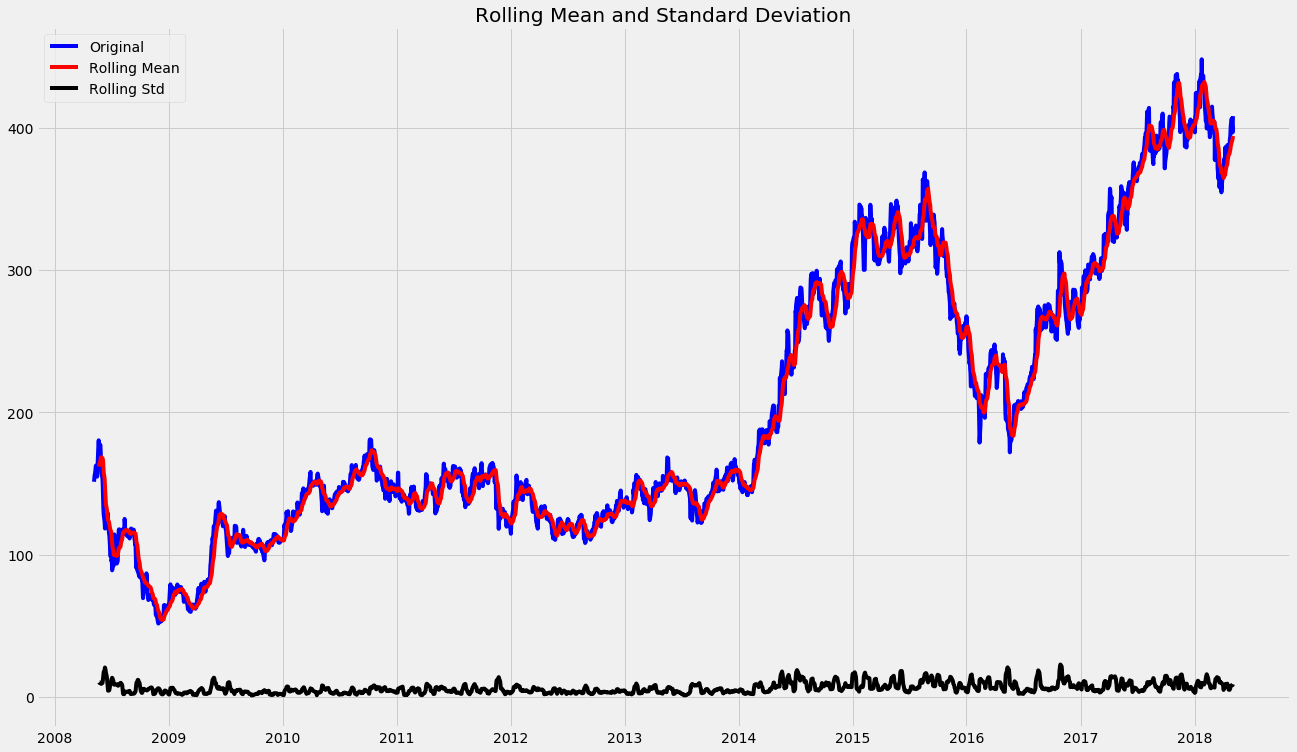

Results of dickey fuller test
Test Statistics                  -0.201997
p-value                           0.938283
No. of lags used                 11.000000
Number of observations used    2449.000000
critical value (1%)              -3.433023
critical value (5%)              -2.862721
critical value (10%)             -2.567399
dtype: float64


In [124]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

The p-value is greater than 0.05 so we cannot reject the Null hypothesis.

The test statistics is greater than the critical values. so the data is non-stationary.

We'll seperate trend and seasonality from the time series to get resultant stationary series in the process

### Decomposition

<Figure size 1440x864 with 0 Axes>

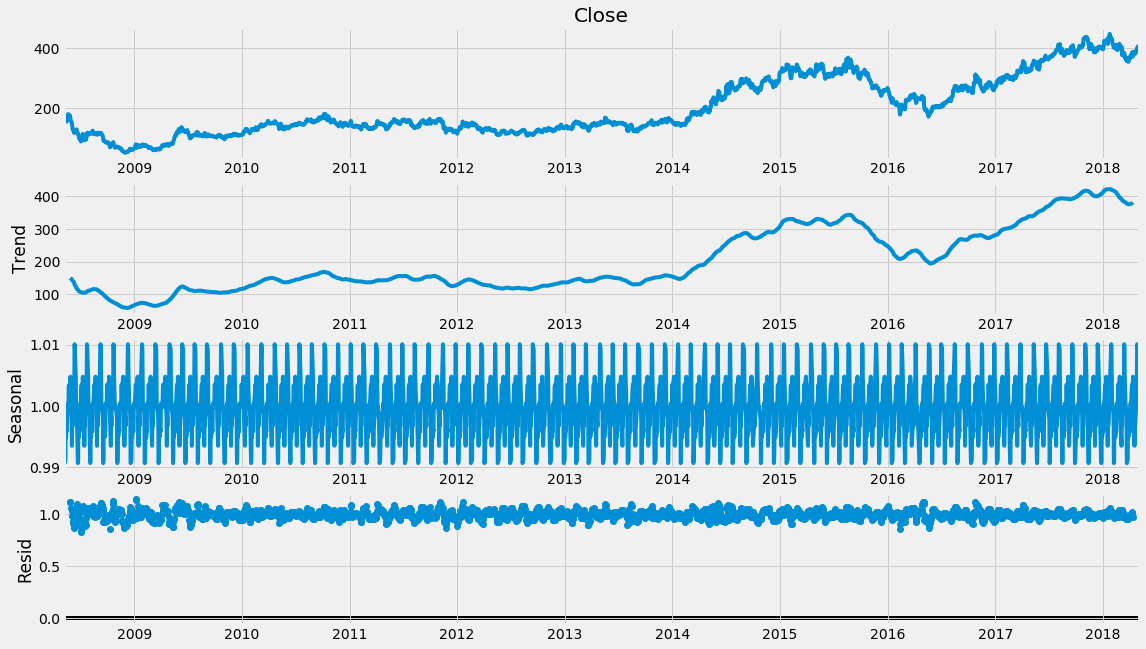

In [126]:
result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We take log of the series to reduce the magnitude of the values and reduce the rising trend in the series

In [130]:
df['Log'] = np.log(df['Close'])
df.head()

,Adj Close,Close,High,Low,Open,Volume,log,Log
Date,,,,,,,,
2008-05-06,134.313477,151.149994,153.570007,147.820007,150.000000,1782030.0,5.018273,5.018273
2008-05-07,136.232864,153.309998,154.460007,150.240005,152.000000,1180015.0,5.032462,5.032462
2008-05-08,138.525497,155.889999,156.759995,150.199997,152.199997,1856245.0,5.049151,5.049151
2008-05-09,139.085312,156.520004,160.600006,154.210007,155.000000,3251375.0,5.053184,5.053184
2008-05-12,144.399170,162.500000,163.479996,151.000000,156.000000,5031635.0,5.090678,5.090678


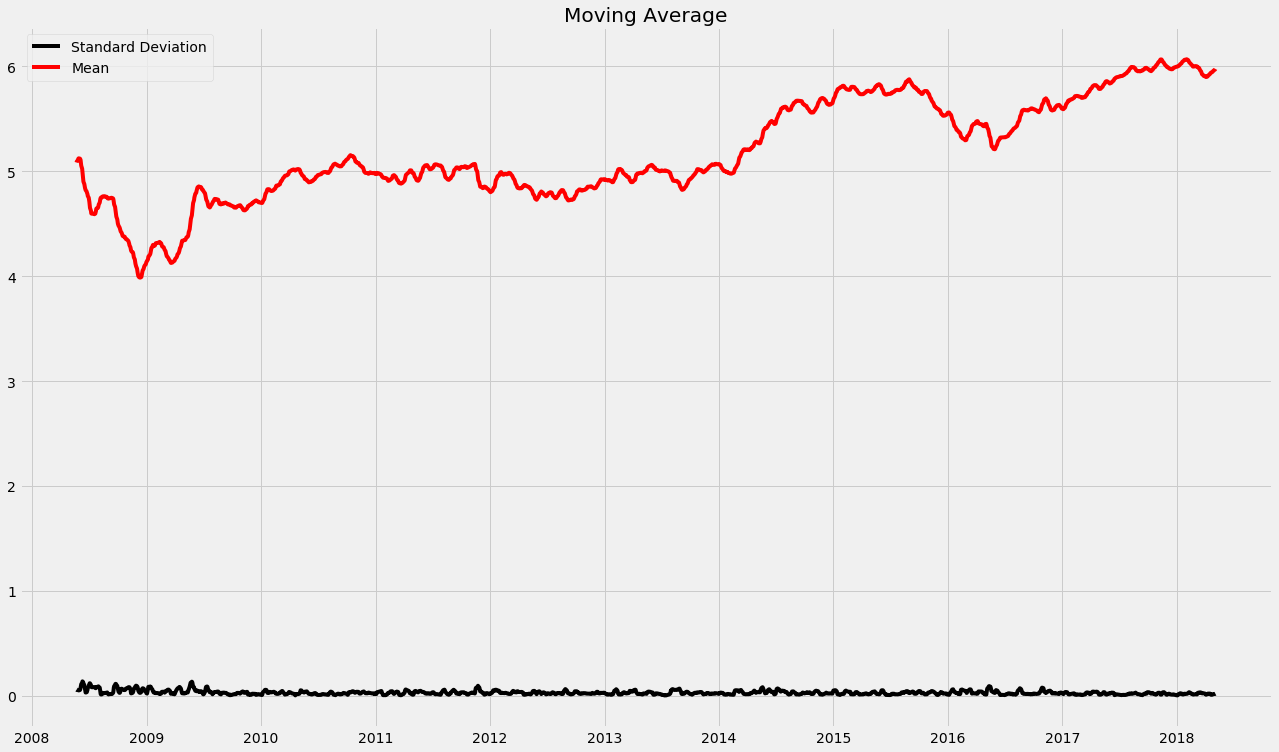

In [170]:
moving_avg = df['Log'].rolling(12).mean()
std_dev = df['Log'].rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

# ARIMA Model

## Splitting Data

In [183]:
k = len(df['Log'])*0.9
train_data, test_data = df['Log'][:int(len(df['Log'])*0.9)], df['Log'][int(len(df['Log'])*0.9):]
test_data.shape

(247,)

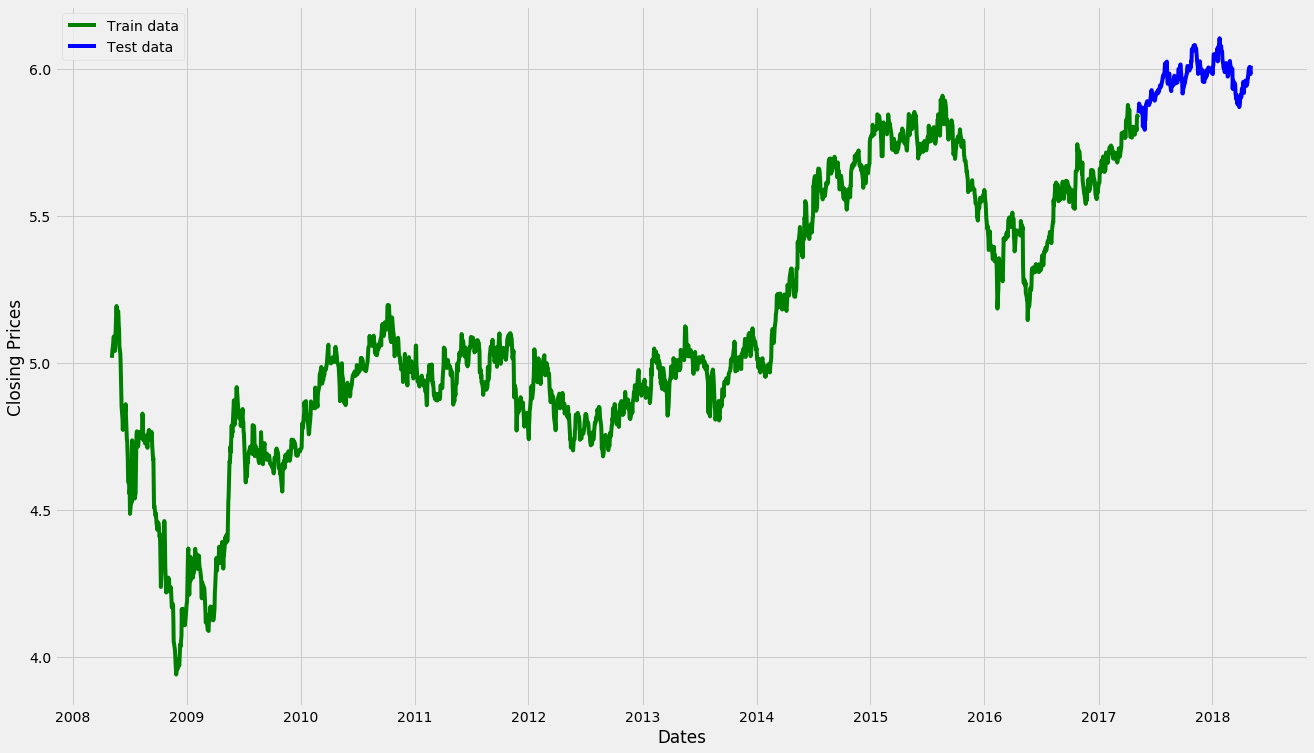

In [173]:
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## Auto ARIMA

Now we need to choose p,q,d for ARIMA model.

But instead of observing ACF and PACF plots we'll use Auto ARIMA to get the best parameters.

The Auto ARIMA function works by conducting different tests like Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron to determine the order of differencing d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges.

If the seasonal optional is enabled the function also seeks to identify the optimal p and q hyper-parameters after conducting the Canova-Hansen to determine the optimal order of seasoning difference, D

In [174]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=2494.605, BIC=2506.010, Time=0.274 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-9759.695, BIC=-9742.587, Time=0.280 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-377.918, BIC=-360.811, Time=0.519 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=13518.244, BIC=13523.946, Time=0.025 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-9760.310, BIC=-9737.500, Time=0.515 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-9759.079, BIC=-9730.566, Time=1.822 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-9759.332, BIC=-9730.819, Time=0.848 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=-2633.481, BIC=-2610.671, Time=0.744 seconds
Fi

We got p, d and q as 2, 0, 0 respectively

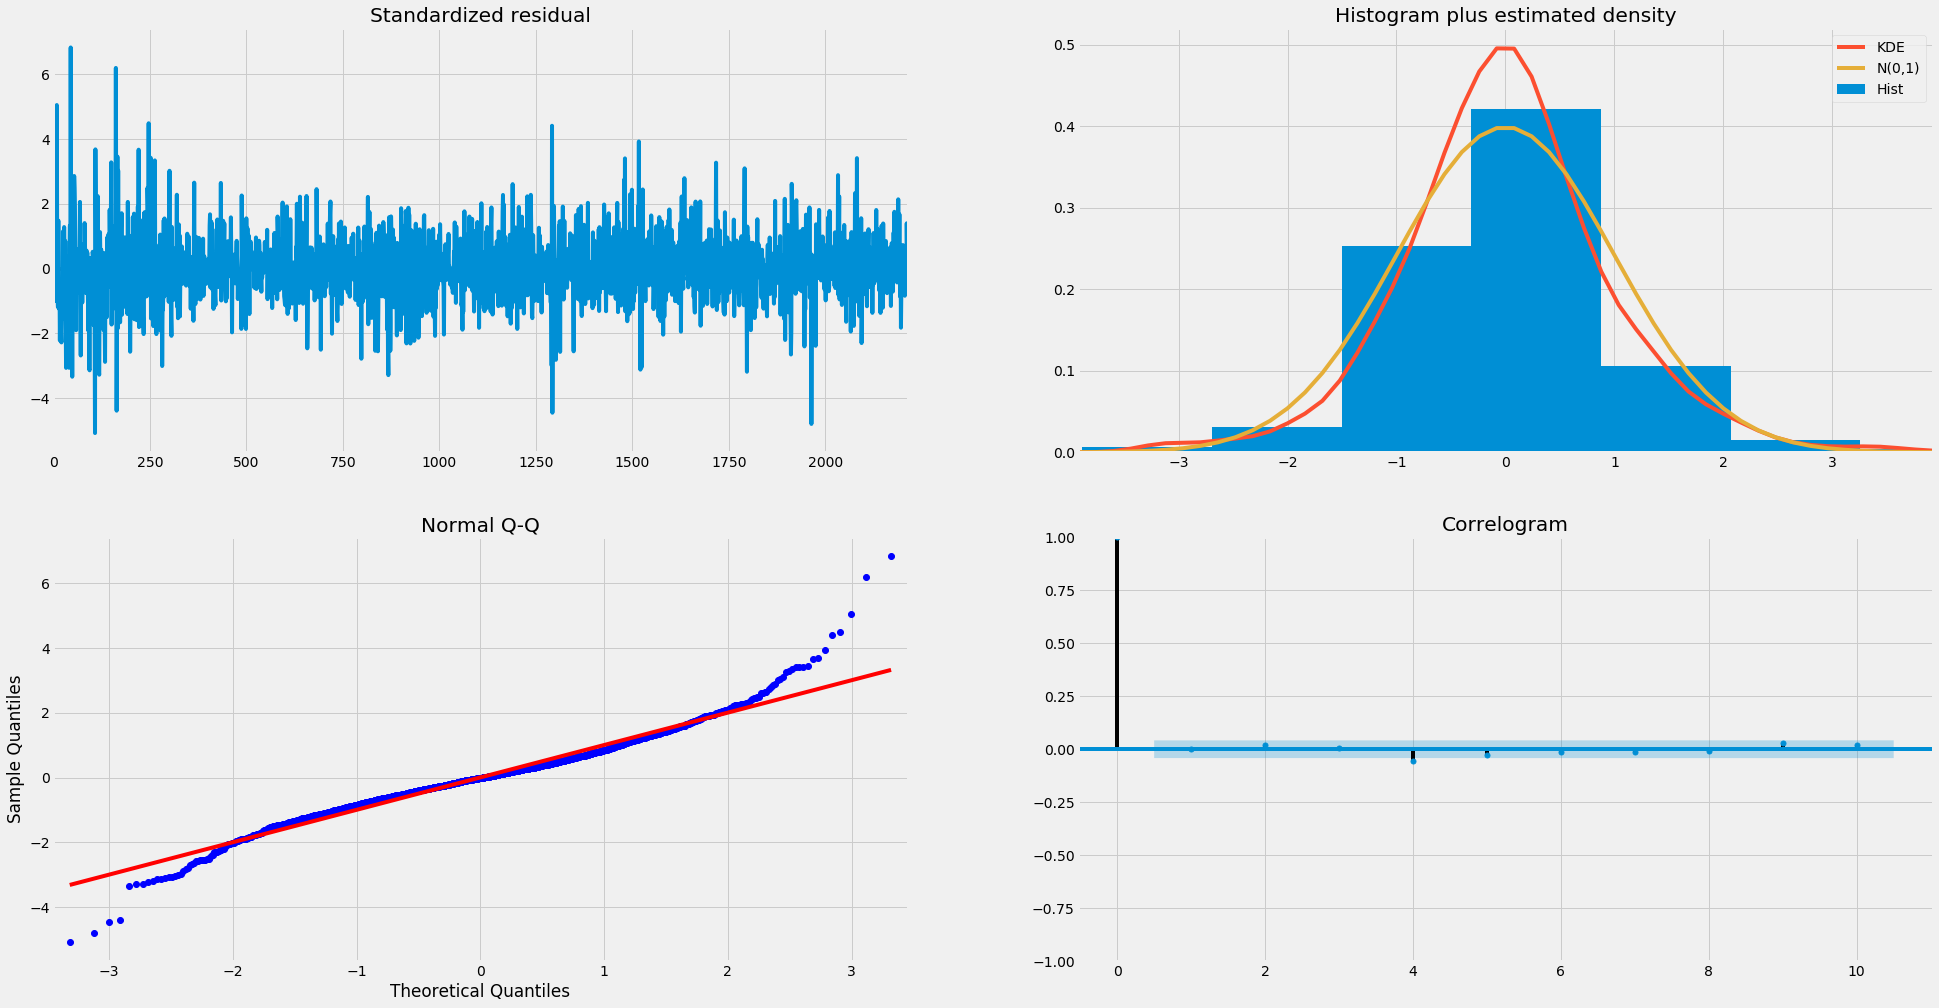

In [175]:
model_autoARIMA.plot_diagnostics(figsize=(30,16))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model

Overall, it seems to be a good fit

### Creating ARIMA model with optimal parameters p, d and q

In [246]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [259]:
mod = ARIMA(train_data, order=(2, 0, 0))
results = mod.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                    Log   No. Observations:                 2214
Model:                     ARMA(2, 0)   Log Likelihood                4884.316
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 20 Apr 2020   AIC                          -9760.633
Time:                        03:56:52   BIC                          -9737.823
Sample:                             0   HQIC                         -9752.301
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2062      0.253     20.608      0.000       4.711       5.701
ar.L1.Log      1.0333      0.021     48.699      0.000       0.992       1.075
ar.L2.Log     -0.0352      0.021     -1.659      0.0

In [260]:
#results.plot_diagnostics(figsize=(20, 16))
#plt.show()

### Forecast with 95% confidence level

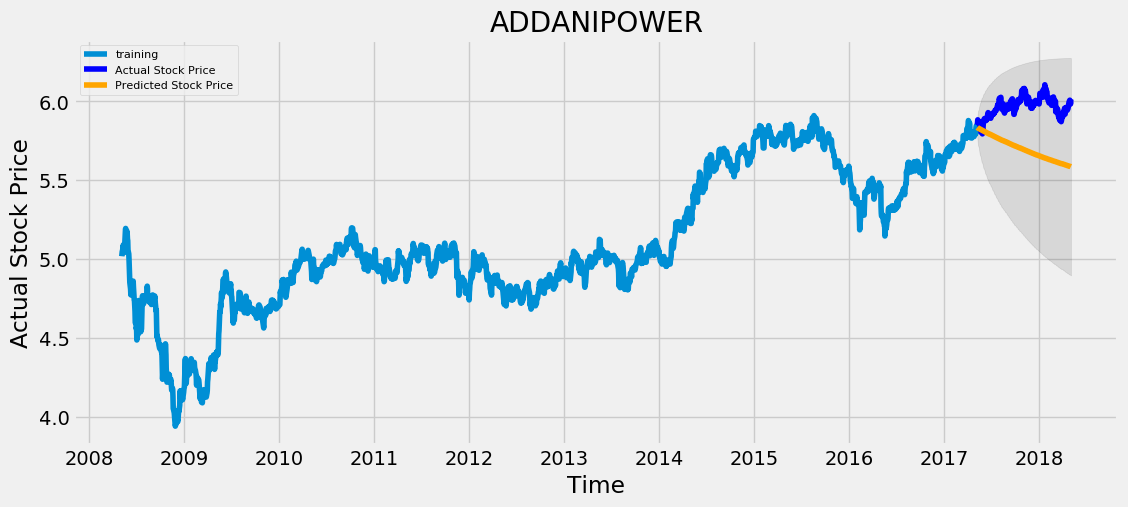

In [269]:
# Forecast
fc, se, conf = fitted.forecast(247, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ADDANIPOWER')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()